In [19]:
print("Hello LangGraph!")

Hello LangGraph!


In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [3]:
import os

from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b



def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


In [4]:
search = DuckDuckGoSearchRun()


In [5]:
tools = [add, multiply, divide, search]
llm_with_tools=llm.bind_tools(tools)
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [6]:
# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")

builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

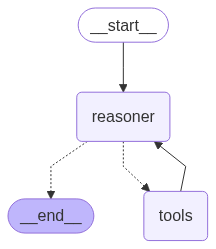

In [7]:

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="What is 2 times of narendramodi's age?")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of narendramodi's age?
================================== Ai Message ==================================

<tool_use>
{
	"tool_call": {
		"id": "pending",
		"type": "function",
		"function": {
			"name": "duckduckgo_search"
		},
		"parameters": {
			"query": "narendra modi age"
		}
	}
}
</tool_use>


In [9]:
messages = [HumanMessage(content="What is the result when you add 100 years to the current age of Elon Musk?")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the result when you add 100 years to the current age of Elon Musk?
================================== Ai Message ==================================
Tool Calls:
  add (call_vhyp)
 Call ID: call_vhyp
  Args:
    a: 100
    b: 51
================================= Tool Message =================================
Name: add

151
================================== Ai Message ==================================
Tool Calls:
  divide (call_z302)
 Call ID: call_z302
  Args:
    a: 151
    b: 1
================================= Tool Message =================================
Name: divide

151.0
================================== Ai Message ==================================

151


In [11]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [14]:
get_stock_price("AAPL")

208.78

In [15]:
# Node
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

tools = [add, multiply, divide, search, get_stock_price]
llm_with_tools = llm.bind_tools(tools)


In [16]:

class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

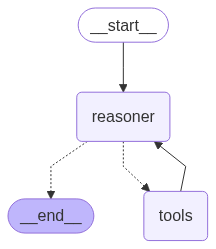

In [17]:
# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [18]:
response = react_graph.invoke({"query": "What is the stock price of Apple add 1000?", "messages": []})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_q3se)
 Call ID: call_q3se
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

208.78
================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_bpb3)
 Call ID: call_bpb3
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

208.78
================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message =====================

## Human in a loop

In [2]:

from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults


from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver


In [5]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [6]:
llm.invoke("hi")

AIMessage(content='Hi there! 👋\n\nHow can I help you today?\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 11, 'total_tokens': 26, 'completion_time': 0.027272727, 'prompt_time': 0.001917655, 'queue_time': 0.26178542499999996, 'total_time': 0.029190382}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--070bb1aa-3325-4692-b1c6-26211ee0d31d-0', usage_metadata={'input_tokens': 11, 'output_tokens': 15, 'total_tokens': 26})

In [7]:
tavily=TavilySearchResults()

In [8]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number


@tool
def search(query:str):
    """perform the web search on the user query"""
    result=tavily.invoke(query)
    return result

In [9]:
tools=[search,multiply]
model_with_tools = llm.bind_tools(tools)
tool_mapping={tool.name: tool for tool in tools}


In [10]:
response = model_with_tools.invoke("who is a current president of USA?")

In [11]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8jnk', 'function': {'arguments': '{"query":"current president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1090, 'total_tokens': 1173, 'completion_time': 0.150909091, 'prompt_time': 0.038107049, 'queue_time': 0.259628111, 'total_time': 0.18901614}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d6d5cb4f-2e23-45be-a20b-91c784781e6c-0', tool_calls=[{'name': 'search', 'args': {'query': 'current president of USA'}, 'id': 'call_8jnk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1090, 'output_tokens': 83, 'total_tokens': 1173})

In [12]:
tool_details=response.additional_kwargs.get("tool_calls")

tool_details

[{'id': 'call_8jnk',
  'function': {'arguments': '{"query":"current president of USA"}',
   'name': 'search'},
  'type': 'function'}]

In [13]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'current president of USA'}

In [14]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))


[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': "Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\nPresident of the United States\n\nThe president of the United States is the:\n\nCurrent president\n\nThe 47th and current president of the United States is Donald John Trump.\xa0He was sworn into office on January 20, 2025.\n\nFormer U.S. presidents [...] The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n\nCurrent vice president\n\nThe 50th and current vice president of the United States is James David (JD) Vance. He was sworn 

In [15]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}    


def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}


def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

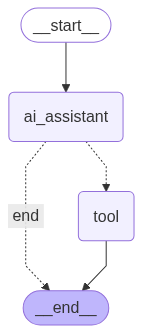

In [16]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)

graph.add_conditional_edges("ai_assistant", 
                            router, 
                            {"tool": "tool","end": END,}
                            )

graph.add_edge("tool", END)
graph.set_entry_point("ai_assistant")
app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))     

In [ ]:
for s in app.stream({"messages": ["what is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_19jy', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 1094, 'total_tokens': 1185, 'completion_time': 0.165454545, 'prompt_time': 0.038387921, 'queue_time': 0.26474728000000003, 'total_time': 0.203842466}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--41e2ecb2-18e4-4594-803b-053d77ab567f-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_19jy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1094, 'output_tokens': 91, 'total_tokens': 1185})]}
----
Selected tool: multiply
{'messages': [1058]}
----


In [ ]:
for s in app.stream({"messages": ["who is upcoming president of USA?"]}): 
    print(list(s.values())[0])
    print("----")